***
# Exemplary Dark Matter Data Release
***

*Correspondence to: felix.wagner@oeaw.ac.at*

Today many experiments search for dark matter particles with low detection thresholds. To enhance the efficient use of the measured data for the calculation of exclusion limits, an open data policy is desirable. In this notebook, we show on mock data how the data formats of a release could be chosen, and summarize some useful information about the joint analysis of data from multiple experiments.

For more information, please look into our ArXive submission: -- add link --

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import expon, norm, uniform, gamma
from scipy import stats
from itertools import product
import numba as nb
from scipy.optimize import fsolve, bisect, minimize
from PIL import Image, ImageDraw
%config InlineBackend.figure_formats = ['svg']

## Get Data

We simulate three mock experiments A, B and C (for uniqueness we will sometimes call them Alice, Bob and Carol). All of them have share the same parametrization of an expected signal model, depending on a paramter $\lambda$. The experiments have individual backgrounds and measurement characteristics, summarized below.

**Measurement Characteristics:**

|                             | Experiment A  |  Experiment B  |  Experiment C  |
|-----------------------------|---------------|----------------|----------------|
| *Exposure* $(kg \cdot d)$   | 7 | 5 | 100 |
| *Rate* $( 1 / (kg \cdot d))$|  300 |   200 |   20 |
| *Counts after Cuts* |  2100 |   1000 |   2000 |
| *Lower Threshold* $(keV)$   |  0.1 |   0.035 |   1 |
| *Upper Threshold* $(keV)$   |  20 |   10 |  400 |
| *Resolution* $(keV)$         |  0.015 |   0.005 |  0.150 |
| *Efficiency above Threshold* |  0.8 |   0.65 |  0.5 |

**Signal models:**

The common signal model $\mathcal{S}$ is:

$$ \mathcal{S}_A(x | \lambda, \omega) = \mathcal{S}_B(x | \lambda, \omega) = \mathcal{S}_C(x | \lambda, \omega) = \omega \cdot \mathcal{Exp}(x | \lambda) $$

... where $x$ is the recoil energy, $\lambda$ a parameter of the dark matter model, $\omega$ is the dark matter cross section with the detector material and $\mathcal{Exp}$ is an exponential distribution.

**Background models:**

The individual background models $\mathcal{B}$ are:

$$ \mathcal{B}_A(x) = 0.4 \cdot \mathcal{U}(x) + 0.3 \cdot \mathcal{N}(x|6,0.5) + 0.3 \cdot \mathcal{E}(x|0.1)$$

$$ \mathcal{B}_B(x) = 0.35 \cdot \mathcal{U}(x) + 0.3 \cdot \mathcal{N}(x|6,0.5) + 0.35 \cdot \mathcal{E}(x|0.1)$$

$$ \mathcal{B}_C(x) = 0.5 \cdot \mathcal{\Gamma}(x|0.375, 933.33) + \sum_i w_i \cdot \mathcal{N}(x|\mu_i,\sigma_i)$$

... with $w = (0.08, 0.12, 0.05, 0.15, 0.1)$, $\mu = (45, 75, 120, 200, 300)$ and $\sigma = (2, 3, 5, 10, 20)$.

In [2]:
NAMES = ['A', 'B', 'C']
EXPOSURE = np.array([7, 5, 100])
COUNTS = np.array([2100, 1000, 2000])
THRESHOLD_LOW = np.array([0.1, 0.035, 1])
THRESHOLD_UP = np.array([20, 10, 400])
RESOLUTION = np.array([0.015, 0.005, 0.15])
EFFICIENCY = np.array([0.8, 0.65, 0.5])
NMBR_REPETITIONS = 10

We define several functions to sample the data of our mock experiments.

In [6]:
def sample_in_region(distribution: object, 
                     upper: float,
                     lower: float,
                     size: int):
    """
    Returns a sample of given size from a distribution, truncated to a certain region of values.
    
    :param distribution: An object which takes only one required, integer argument: size. This is the desired sample size.
    :type distribution: object
    :param upper: The upper truncation limit for the distribution.
    :type upper: float
    :param lower: The lower truncation limit for the distribution.
    :type lower: float
    :param size: The desired sample size.
    :type size: int
    :return: The sample from the distribution.
    :rtype: np.array
    """
    retval = np.zeros(size)
    while True:
        cond = np.logical_or(retval < lower, retval > upper)
        if any(cond):
            retval[cond] = distribution(size=np.sum(cond))
        else:
            return retval

In [7]:
def bck_alice(size:int): 
    """
    The distribution object for the background model of experiment A.
    
    :param size: The desired sample size.
    :type size: int
    :return: The sample from the background model.
    :rtype: np.array
    """
    retval = np.empty(size, dtype=float)
    randvals = np.random.uniform(size=size)
    retval[randvals < 0.4] = np.random.uniform(THRESHOLD_LOW[0],THRESHOLD_UP[0],size=np.sum(randvals < 0.4)) # flat bck
    retval[np.logical_and(randvals >= 0.4, randvals < 0.7)] = np.random.normal(6,0.5,size=np.sum(np.logical_and(randvals >= 0.4, randvals < 0.7))) # peaks
    retval[randvals >= 0.7] = np.random.exponential(0.1,size=np.sum(randvals >= 0.7))
    retval += np.random.normal(0,RESOLUTION[0],size=size) # resolution
    return retval

def bck_bob(size:int): 
    """
    The distribution object for the background model of experiment B.
    
    :param size: The desired sample size.
    :type size: int
    :return: The sample from the background model.
    :rtype: np.array
    """
    retval = np.empty(size, dtype=float)
    randvals = np.random.uniform(size=size)
    retval[randvals < 0.35] = np.random.uniform(THRESHOLD_LOW[1],THRESHOLD_UP[1],size=np.sum(randvals < 0.35)) # flat bck
    retval[np.logical_and(randvals >= 0.35, randvals < 0.65)] = np.random.normal(6,0.5,size=np.sum(np.logical_and(randvals >= 0.35, randvals < 0.65))) # peaks
    retval[randvals >= 0.65] = np.random.exponential(0.1,size=np.sum(randvals >= 0.65))
    retval += np.random.normal(0,RESOLUTION[1],size=size) # resolution
    return retval

def bck_carol(size:int): 
    """
    The distribution object for the background model of experiment C.
    
    :param size: The desired sample size.
    :type size: int
    :return: The sample from the background model.
    :rtype: np.array
    """
    retval = np.empty(size, dtype=float)
    randvals = np.random.uniform(size=size)
    retval[randvals < 0.5] = np.random.gamma(2.25,66.67,size=np.sum(randvals < 0.5)) # flat bck
    w = [0, 0.08, 0.12, 0.05, 0.15, 0.1]
    mu = [45, 75, 120, 200, 300]
    sigma = [2, 3, 5, 10, 15]
    for i in range(5):
        retval[np.logical_and(randvals >= 0.5 + w[i], randvals < 0.5 + w[i+1])] = np.random.normal(loc=mu[i],scale=sigma[i],size=np.sum(np.logical_and(randvals >= 0.5 + w[i], randvals < 0.5 + w[i+1]))) # peaks
    retval += np.random.normal(0,RESOLUTION[2],size=size) # resolution
    return retval

With the above defined functions, we are ready to sample the background data of our three experiments. Because we are in the merry position that we can sample as much statistics as we want, we repeat the sampling a certain number of times. With the redundant data sets, we will calculate confidence levels for the exclusion limits later.

In [8]:
data_alice = [sample_in_region(bck_alice, lower=THRESHOLD_LOW[0], upper=THRESHOLD_UP[0], size=COUNTS[0]) for i in range(NMBR_REPETITIONS)]
data_bob = [sample_in_region(bck_bob, lower=THRESHOLD_LOW[1], upper=THRESHOLD_UP[1], size=COUNTS[1]) for i in range(NMBR_REPETITIONS)]
data_carol = [sample_in_region(bck_carol, lower=THRESHOLD_LOW[2], upper=THRESHOLD_UP[2], size=COUNTS[2]) for i in range(NMBR_REPETITIONS)]

Lets have a look at the energy spectra of our experiments.

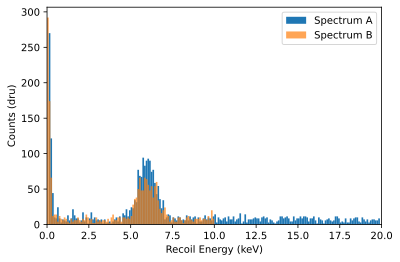

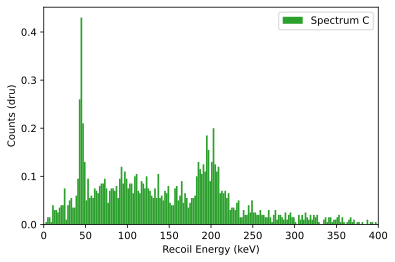

In [13]:
bin_width = 0.1
ran = (0,20)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_alice[0], bins=bins, weights=1/bin_width/EXPOSURE[0]*np.ones(len(data_alice[0])), alpha=1, label='Spectrum A', range=ran)
plt.hist(data_bob[0], bins=bins, weights=1/bin_width/EXPOSURE[1]*np.ones(len(data_bob[0])), alpha=0.7, label='Spectrum B', range=ran)
plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.legend()
plt.show()

bin_width = 2
ran = (0,400)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_carol[0], bins=bins, weights=1/bin_width/EXPOSURE[2]*np.ones(len(data_carol[0])), alpha=1, label='Spectrum C', range=ran, color='C2')
plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.legend()
plt.show()

We assume, that no energy dependent cuts or event rejection effects (like pile-up) were present in the process of data collection and analysis. In this case, we can create our cut efficiencies from a simple model, which depends only on the detector resolution, the threshold and the constant survival probability above threshold.

In [10]:
def threshold_model(x, a0, a1, a2):
    """
    Fit model for the threshold.

    :param x: The grid on which the model is evaluated.
    :type x: array
    :param a0: Estimated constant survival probability above threshold.
    :type a0: float
    :param a1: Estimated threshold value.
    :type a1: float
    :param a2: Estimator for the energy resolution.
    :type a2: float
    :return: The evaluated error function
    :rtype: array
    """
    return 0.5 * a0 * (1 + erf((x - a1) / (np.sqrt(2) * a2)))

In [11]:
grids = np.array([np.arange(0, THRESHOLD_UP[i], THRESHOLD_UP[i]/5000) for i in range(3)])
efficiencies = np.array([threshold_model(grids[i],
                           a0=EFFICIENCY[i],
                           a1=THRESHOLD_LOW[i],
                           a2=RESOLUTION[i]) for i in range(3)])

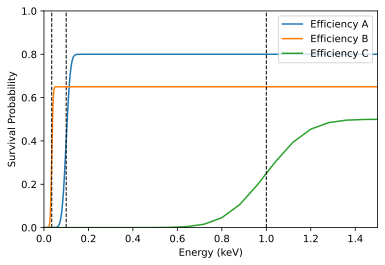

In [12]:
for grid, eff, tv, lab in zip(grids, efficiencies, THRESHOLD_LOW, NAMES):
    plt.plot(grid, eff, label='Efficiency ' + lab)
    plt.axvline(x=tv, color='black', linewidth=1, linestyle='dashed')
plt.xlabel('Energy (keV)')
plt.ylabel('Survival Probability')
plt.xlim(0,1.5)
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.show()

The cut efficiencies can be used to re-weight the bins of the energy spectra and reconstruct the estimated event rate in DRU.

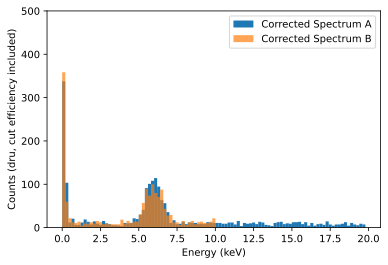

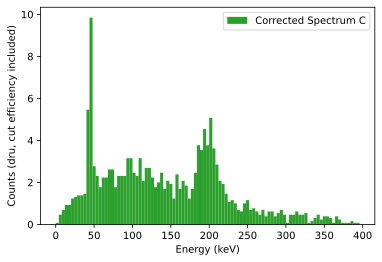

In [15]:
bin_width = 0.2
ran = (0,20)
bins = np.arange(ran[0],ran[1],bin_width)

for i, (data, name) in enumerate(zip([data_alice[0], data_bob[0]], NAMES[:2])):
    
    hist, bins = np.histogram(data, bins=bins, range=(THRESHOLD_LOW[i], THRESHOLD_UP[i]))
    bins_center = bins[:-1] + (bins[1:] - bins[:-1])/2
    hist = hist / np.interp(bins_center, grids[i], efficiencies[i])
    plt.hist(bins_center, bins, weights=hist/EXPOSURE[i]/bin_width, label='Corrected Spectrum ' + name, alpha=1-0.3*i)

plt.ylim(0,500)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts (dru, cut efficiency included)')
plt.legend()
plt.show()

bin_width = 4
ran = (0,400)
bins = np.arange(ran[0],ran[1],bin_width)

hist, bins = np.histogram(data_carol[0], bins=bins, range=(THRESHOLD_LOW[i], THRESHOLD_UP[i]))
bins_center = bins[:-1] + (bins[1:] - bins[:-1])/2
hist = hist / np.interp(bins_center, grids[i], efficiencies[i])
plt.hist(bins_center, bins, weights=hist/EXPOSURE[i]/bin_width, label='Corrected Spectrum ' + NAMES[2], color='C2')

plt.xlabel('Energy (keV)')
plt.ylabel('Counts (dru, cut efficiency included)')
plt.legend()
plt.show()

## Export the data

We export the data sets in a suitable data format. This format is especially independent of any specific software tools and can therefore be processed by anyone.

In [20]:
np.savetxt('data/alice/data_alice.txt', np.column_stack([data_alice[0]]))
np.savetxt('data/bob/data_bob.txt', np.column_stack([data_bob[0]]))
np.savetxt('data/carol/data_carol.txt', np.column_stack([data_carol[0]]))

In [21]:
np.savetxt('data/alice/efficiency_alice.txt', np.column_stack([grids[0], efficiencies[0]]))
np.savetxt('data/bob/efficiency_bob.txt', np.column_stack([grids[1], efficiencies[1]]))
np.savetxt('data/carol/efficiency_carol.txt', np.column_stack([grids[2], efficiencies[2]]))

## Trigger efficiency effects

When comparing energy spectra of different experiments, one has to take care of a curious effect. Assume, two experiments observe the same signal. The efficiency correction of the histogram is needed to create comparable count rates. However, the efficiency is typically stated w.r.t. a simulated, true energy, while the energy spectrum is stated w.r.t. the measured energy. This corresponds to a convolution effect on the energy spectrum, and produces a virtual blow-up of the spectrum close to the energy threshold. The effect is visualized below.

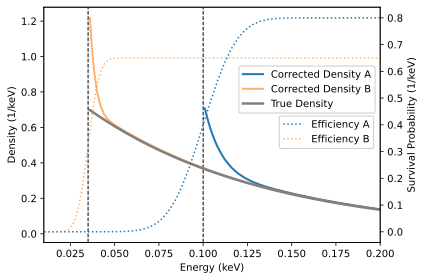

In [32]:
bin_width = 0.001
ran = (0.01,0.2)
bins = np.arange(ran[0],2*ran[1],bin_width)

grid_data = [bins[np.logical_and(bins > THRESHOLD_LOW[i], bins < THRESHOLD_UP[i])] for i in range(2)]

mock = []
mock_true = []
for i in range(2):
    temp = np.exp(-bins/0.1)
    kernel = norm.pdf(np.arange(-3*RESOLUTION[i], 3*RESOLUTION[i], bin_width), loc=0, scale=RESOLUTION[i])
    kernel /= np.sum(kernel)
    lek = len(kernel)
    let = len(temp)
    if lek > let:
        kernel = kernel[int((lek - let)/2):-int((lek - let)/2)]
    mock_true.append(temp[np.logical_and(bins > THRESHOLD_LOW[i], bins < THRESHOLD_UP[i])])
    mock.append(np.convolve(a=temp, v=kernel, mode='same')[np.logical_and(bins > THRESHOLD_LOW[i], bins < THRESHOLD_UP[i])])

fig, host = plt.subplots()
par1 = host.twinx()

host.set_xlabel('Energy (keV)')
host.set_ylabel('Density (1/keV)')
par1.set_ylabel('Survival Probability (1/keV)')

color1 = 'black'
color2 = 'black'

linestyles = ['dotted', 'dashed']

for i in range(2):
    
    denum = np.interp(grid_data[i], grids[i], efficiencies[i])
    _ = host.plot(grid_data[i], mock[i]/denum*EFFICIENCY[i], label='Corrected Density ' + NAMES[i], color='C'+str(i), linewidth=2, alpha=1-0.4*i)
    if i == 1:
        _ = host.plot(grid_data[i], mock_true[i], color='grey', linewidth=2.5, linestyle='solid', alpha=1, label='True Density')
    
    _ = par1.plot(grids[i], efficiencies[i], label='Efficiency ' + NAMES[i], 
              color='C'+str(i), alpha=1-0.4*i, linestyle='dotted') #  linestyles[i])
    host.axvline(x=THRESHOLD_LOW[i], color='black', linewidth=1, linestyle='dashed')

host.yaxis.label.set_color(color1)
par1.yaxis.label.set_color(color2)

fig.tight_layout()

plt.xlim(ran)
host.legend(loc=(0.58, 0.55), fancybox=True, framealpha=1)
par1.legend(loc=(0.7, 0.4), fancybox=True, framealpha=1)

plt.savefig('plots/effprob.pdf')
plt.show()

## Exclusion limits with Yellin

We will now proceed and calculate combined limits for above experiments. Limits are calculated with Yellins Maximum Gap method, and a likelihood approach.

We create objects for our expected signal models, which are needed for the calculation of limits.

In [33]:
def sig(x, args, grid, efficiency, exposure):  # assumes equidistant grid of efficiency
    """
    TODO
    """
    
    scale = args[0]
    
    signal_model = np.cumsum(expon.pdf(grid, scale=scale) * efficiency)*(grid[1] - grid[0])
    retval = np.interp(x, grid, signal_model) * exposure
    
    return retval

def sig_combined(x:list, args: list, grids: list, efficiencies: list, exposures: list):
    """
    TODO
    """
    
    assert len(grids) == len(efficiencies) == len(exposures), 'The lists must have same length!'
    
    scale = args[0]
    
    retval = 0
    
    for i in range(len(efficiencies)):
        signal_model = np.cumsum(expon.pdf(grids[i], scale=scale) * efficiencies[i])*(grids[i][1] - grids[i][0])
        retval += np.interp(x, grid, signal_model) * exposures[i]
    
    return retval

First, we show the steps of a Yellin limit calculation individually. This includes the calculation of the expectations in all gaps. Aferwards, we find the exclusion limit with the expectation in the largest gap.

We calculate for a given signal parameter the number of totally expected signal events in all experiments indivudally, and combined.

In [48]:
LAMB = 1

expectations = []
extended_energies = []
total_expected = []

# individual expectations
data_alice_sorted = np.sort(data_alice[0])
data_bob_sorted = np.sort(data_bob[0])
data_carol_sorted = np.sort(data_carol[0])

for i, data in enumerate([data_alice_sorted, data_bob_sorted, data_carol_sorted]):
    extended_energies.append(np.concatenate(([THRESHOLD_LOW[i]- 2*RESOLUTION[i]], data, [THRESHOLD_UP[i]])))
    cumsignal = sig(x=extended_energies[-1], 
                    args=[LAMB], grid=grids[i], efficiency=efficiencies[i],
                    exposure=EXPOSURE[i])
    expectations.append(np.diff(cumsignal))
    total_expected.append(cumsignal[-1] - cumsignal[0])
    
# combined expectations
for idx, datas in zip([[0,1], [0,2], [1,2], [0,1,2]], 
                      [[data_alice[0], data_bob[0]], [data_alice[0], data_carol[0]], [data_bob[0], data_carol[0]], [data_alice[0], data_bob[0], data_carol[0]]]):
    data = np.sort(np.concatenate(datas, axis=0))
    extended_energies.append(np.concatenate(([np.min(THRESHOLD_LOW[idx]- 2*RESOLUTION[idx])], 
                                             data, 
                                             [np.max(THRESHOLD_UP[idx])])))
    cumsignal = sig_combined(x=extended_energies[-1], 
                             args=[LAMB], 
                             grids=grids[idx], 
                             efficiencies=efficiencies[idx],
                             exposures=EXPOSURE[idx])
    expectations.append(np.diff(cumsignal))
    total_expected.append(cumsignal[-1] - cumsignal[0])


The following cell computes plot of the expectations for several signal parameters, for better visualization of the process.

In [38]:
DPI=150

for j,LAMB in enumerate(np.logspace(-1,1,num=10)):
    
    if LAMB == 0.1:
        print('\n LAMB: {}'.format(LAMB))

    expectations = []
    extended_energies = []
    total_expected = []

    # individual expectations
    data_alice_sorted = np.sort(data_alice[0])
    data_bob_sorted = np.sort(data_bob[0])
    data_carol_sorted = np.sort(data_carol[0])

    for i, data in enumerate([data_alice_sorted, data_bob_sorted, data_carol_sorted]):
        extended_energies.append(np.concatenate(([THRESHOLD_LOW[i]- 2*RESOLUTION[i]], data, [THRESHOLD_UP[i]])))
        cumsignal = sig(x=extended_energies[-1], 
                        args=[LAMB], grid=grids[i], efficiency=efficiencies[i],
                        exposure=EXPOSURE[i])
        expectations.append(np.diff(cumsignal))
        total_expected.append(cumsignal[-1] - cumsignal[0])

    # combined expectations
    for idx, datas in zip([[0,1], [0,2], [1,2], [0,1,2]], 
                          [[data_alice[0], data_bob[0]], [data_alice[0], data_carol[0]], [data_bob[0], data_carol[0]], [data_alice[0], data_bob[0], data_carol[0]]]):
        data = np.sort(np.concatenate(datas, axis=0))
        extended_energies.append(np.concatenate(([np.min(THRESHOLD_LOW[idx]- 2*RESOLUTION[idx])], 
                                                 data, 
                                                 [np.max(THRESHOLD_UP[idx])])))
        cumsignal = sig_combined(x=extended_energies[-1], 
                                 args=[LAMB], 
                                 grids=grids[idx], 
                                 efficiencies=efficiencies[idx],
                                 exposures=EXPOSURE[idx])
        expectations.append(np.diff(cumsignal))
        total_expected.append(cumsignal[-1] - cumsignal[0])


    nam = NAMES.copy()
    nam.append(NAMES[0] + ' and ' + NAMES[1])
    nam.append(NAMES[0] + ' and ' + NAMES[2])
    nam.append(NAMES[1] + ' and ' + NAMES[2])
    
    # plots
    
    lims = {'xlim': [(0,20),(0,10),(0,400),(0,20),(0,400),(0,400)],
           'ylim': [(0,0.3),(0,0.2),(0,18),(0,0.03),(0,2),(0,2)]}

    fig, axes = plt.subplots(2,3,figsize=(10,6), sharey=False)
    for i in range(6):
        if LAMB == 0.1:
            print('Total Expected in {}: {}'.format(nam[i], total_expected[i]))
        axes[int(i/3),i%3].scatter((extended_energies[i][1:] - extended_energies[i][:-1])/2 + extended_energies[i][:-1], 
                    expectations[i], 
                    color='C' + str(i), rasterized=True, s=10, marker='.', label=nam[i])
        axes[int(i/3),i%3].legend(loc='upper right')
        axes[int(i/3),i%3].set_xlim(lims['xlim'][i])
        axes[int(i/3),i%3].set_ylim(lims['ylim'][i])
    fig.supxlabel('Recoil Energy (keV)')
    fig.supylabel('Gap Size (1/$\sigma$)')
    fig.suptitle(f'Signal Paramter $\lambda$: {LAMB:5.2f}')
    plt.tight_layout()
    plt.savefig('plots/gap_size_{}.png'.format(j), dpi=DPI)
    plt.close()

    fig, ax = plt.subplots(1,1,figsize=(6,4))
    nam = NAMES[0] + ' and ' + NAMES[1] + ' and ' + NAMES[2]
    if LAMB == 0.1:
        print('Total Expected in {}: {}'.format(nam, total_expected[6]))
    ax.scatter((extended_energies[6][1:] - extended_energies[6][:-1])/2 + extended_energies[6][:-1], 
                expectations[6], 
                color='C' + str(6), rasterized=True, s=10, marker='.', label=nam)
    ax.legend()
    ax.set_ylim(0,0.4)
    ax.set_xlim(0,400)
    fig.supxlabel('Recoil Energy (keV)')
    fig.supylabel('Gap Size (1/$\sigma$)')
    fig.suptitle(f'Signal Paramter $\lambda$: {LAMB:5.2f}')
    plt.tight_layout()
    plt.savefig('plots/gap_size_all_{}.png'.format(j), dpi=DPI)
    plt.close()


 LAMB: 0.1
Total Expected in A: 2.078074629973724
Total Expected in B: 2.2911514200009577
Total Expected in C: 0.005389999273334684
Total Expected in A and B: 4.354603746698941
Total Expected in A and C: 2.0904242069796983
Total Expected in B and C: 2.3000929554044016
Total Expected in A and B and C: 4.383525088281876


We put the plots together to a GIF. The GIF can be viewed in the folder `plots/`.

In [39]:
images = []

for i in range(10):
    images.append(Image.open('plots/gap_size_{}.png'.format(i)))
    images[0].save('plots/gap_size.gif', format='GIF', save_all=True, append_images=images[1:], duration=300, loop=0)
    
images = []

for i in range(10):
    images.append(Image.open('plots/gap_size_all_{}.png'.format(i)))
    images[0].save('plots/gap_size_all.gif', format='GIF', save_all=True, append_images=images[1:], duration=300, loop=0)

We obtain the 90 % confidence limit on the cross section, which is a linear prefactor on the otherwise fully determined signal model, by solving the implicit equation:

$$ 0.9 = C_{0}(x, \mu)=\sum_{k=0}^{m} \frac{(k x-\mu)^{k} e^{-k x}}{k !}\left(1+\frac{k}{\mu-k x}\right) $$

with mu ... expectation in the whole region,

sigma ... linear prefactor of signal model,

with N ... expected number of events, 

m ... int(mu/x), 

x ... expectation in the gap.

In [43]:
def _C0(mu, x):
    retval = 0
    for k in range(int(mu/x)+1):
        fact = np.math.factorial(k)
        if fact > 0:
            added = (k*x - mu)**k*np.exp(-k*x)*(1 + k/(mu - k*x))
            added /= fact
            if np.isclose(retval + added, retval) or fact > 1e100:  # truncate the sum
                break
            else:
                retval += added
        else:
            pass
    retval = np.maximum(retval,0)
    return retval

vec_C0 = np.vectorize(_C0)

In [82]:
def _solve_impl(f):
    a, b = 1e-2, 1e6 
    return bisect(f, a, b)

We calcualte the limits for a given signal parameter, for all combinations of experiments.

In [78]:
LAMB = 1

print('Signal Parameter: ', LAMB)

print('\n>>> Individual Limits')

for i in range(3):
    limit = _solve_impl(lambda sigma: _C0(mu=sigma*total_expected[i], x=sigma*np.max(expectations[i])) - 0.9)
    print('Limit {}: {}'.format(NAMES[i], limit))

# combined 

print('\n>>> Combined Limits')
    
for n, (i,j) in enumerate([(0,1), (0,2), (1,2)]):
    limit = _solve_impl(lambda sigma: _C0(mu=sigma*total_expected[n+3], x=sigma*np.max(expectations[n+3])) - 0.9)
    print('{}: {}'.format(NAMES[i] + ' and ' + NAMES[j], limit))
    
limit = _solve_impl(lambda sigma: _C0(mu=sigma*total_expected[6], x=sigma*np.max(expectations[6])) - 0.9)
print('{}: {}'.format(NAMES[0] + ' and ' + NAMES[1] + ' and ' + NAMES[2], limit))

Signal Parameter:  1

>>> Individual Limits
Limit A: 41.43010008177719
Limit B: 67.93897701903884
Limit C: 0.2551365680512169

>>> Combined Limits
A and B: 293.0376339486894
A and C: 11.19351632805884
B and C: 6.392842625229951
A and B and C: 12.305696956895911


We define now a function that combines all above calculations for a given set of experiments.

In [79]:
def get_limit(pars: list, data:list, grids:list, efficiencies:list, signal_model:object,
             exposures: list, thresholds_low: list, thresholds_up:list, resolutions:list):
    
    assert len(data) == len(grids) == len(efficiencies), 'the handed lists must have same length!'
    # assert combine, 'combine not yet implemented'
    
    limits = np.empty(len(pars), dtype=float)
    data_sorted = np.sort(np.concatenate(data, axis=0))
    
    for i,p in enumerate(pars):

        # calc expectations and total expected

        expectations = []
        total_expected = []
        
        extended_energies = np.concatenate(([np.min(thresholds_low - 2*resolutions)], 
                                 data_sorted, 
                                 [np.max(thresholds_up)]))
        cumsignal = signal_model(x=extended_energies, 
                         args=[p], 
                         grids=grids, 
                         efficiencies=efficiencies,
                         exposures=exposures)

        expectation = np.diff(cumsignal)
        total_expected = cumsignal[-1] - cumsignal[0]

        # calc limit
        
        def implfunc(sigma):
            return _C0(mu=sigma*total_expected, 
                       x=sigma*np.max(expectation)) - 0.9
        
        try:
            limits[i] = _solve_impl(implfunc)
        except KeyError:
            raise KeyError('The prefactor lambda gets loo large for the scale parameter {}'.format(p))
        
    return limits

We calculate the limits for a number of signal parameters.

In [83]:
num=70

print('Calculate individual Limits...')
pars_alice = np.logspace(-1.5,1,num=num)
pars_bob = np.logspace(-2,1,num=num)
pars_carol = np.logspace(-0.5,2,num=num)

limit_alice = [get_limit(pars=pars_alice, 
                        data=[data_alice[i]], 
                        grids=grids[[0]], 
                        efficiencies=efficiencies[[0]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[0]], 
                        thresholds_low=THRESHOLD_LOW[[0]], 
                        thresholds_up=THRESHOLD_UP[[0]], 
                        resolutions=RESOLUTION[[0]]) for i in range(NMBR_REPETITIONS)]

limit_bob = [get_limit(pars_bob, [data_bob[i]], 
                        grids=grids[[1]], 
                        efficiencies=efficiencies[[1]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[1]], 
                        thresholds_low=THRESHOLD_LOW[[1]], 
                        thresholds_up=THRESHOLD_UP[[1]], 
                        resolutions=RESOLUTION[[1]]) for i in range(NMBR_REPETITIONS)]

limit_carol = [get_limit(pars_carol, [data_carol[i]], 
                        grids=grids[[2]], 
                        efficiencies=efficiencies[[2]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[2]], 
                        thresholds_low=THRESHOLD_LOW[[2]], 
                        thresholds_up=THRESHOLD_UP[[2]], 
                        resolutions=RESOLUTION[[2]]) for i in range(NMBR_REPETITIONS)]

print('Calculate two-experiment Limits...')
pars_ab = np.logspace(-2,1,num=num)
pars_ac = np.logspace(-1.5,1.8,num=num)
pars_bc = np.logspace(-2,2,num=num)

limit_ab = [get_limit(pars_ab, [data_alice[i], data_bob[i]], 
                        grids=grids[[0,1]], 
                        efficiencies=efficiencies[[0,1]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[0,1]], 
                        thresholds_low=THRESHOLD_LOW[[0,1]], 
                        thresholds_up=THRESHOLD_UP[[0,1]], 
                        resolutions=RESOLUTION[[0,1]]) for i in range(NMBR_REPETITIONS)]

limit_ac = [get_limit(pars_ac, [data_alice[i], data_carol[i]], 
                        grids=grids[[0,2]], 
                        efficiencies=efficiencies[[0,2]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[0,2]], 
                        thresholds_low=THRESHOLD_LOW[[0,2]], 
                        thresholds_up=THRESHOLD_UP[[0,2]], 
                        resolutions=RESOLUTION[[0,2]]) for i in range(NMBR_REPETITIONS)]

limit_bc = [get_limit(pars_bc, [data_bob[i], data_carol[i]], 
                        grids=grids[[1,2]], 
                        efficiencies=efficiencies[[1,2]], 
                        signal_model=sig_combined,
                        exposures=EXPOSURE[[1,2]], 
                        thresholds_low=THRESHOLD_LOW[[1,2]], 
                        thresholds_up=THRESHOLD_UP[[1,2]], 
                        resolutions=RESOLUTION[[1,2]]) for i in range(NMBR_REPETITIONS)]

print('Calculate combined Limit ...')
pars_all = np.logspace(-2,2,num=num)

limit_all = [get_limit(pars_all, [data_alice[i], data_bob[i], data_carol[i]], 
                      grids, efficiencies, sig_combined, 
                      EXPOSURE, THRESHOLD_LOW, THRESHOLD_UP, RESOLUTION) for i in range(NMBR_REPETITIONS)]


Calculate individual Limits...
Calculate two-experiment Limits...
Calculate combined Limit ...


Now we plot the averaged limits for comparison, with uncertainty intervals.

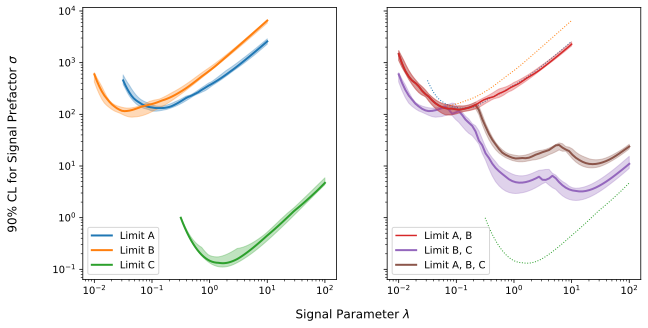

In [84]:
fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].loglog(pars_alice, np.quantile(limit_alice, q=0.5, axis=0), label='Limit ' + NAMES[0], linewidth=2, color='C0')
axes[0].loglog(pars_bob, np.quantile(limit_bob, q=0.5, axis=0), label='Limit ' + NAMES[1], linewidth=2, color='C1')
axes[0].loglog(pars_carol, np.quantile(limit_carol, q=0.5, axis=0), label='Limit ' + NAMES[2], linewidth=2, color='C2')
axes[0].fill_between(pars_alice, y1=np.quantile(limit_alice, q=0.75, axis=0),
                    y2=np.quantile(limit_alice, q=0.25, axis=0), color='C0', alpha=0.3)
axes[0].fill_between(pars_bob, y1=np.quantile(limit_bob, q=0.75, axis=0),
                    y2=np.quantile(limit_bob, q=0.25, axis=0), color='C1', alpha=0.3)
axes[0].fill_between(pars_carol, y1=np.quantile(limit_carol, q=0.75, axis=0),
                    y2=np.quantile(limit_carol, q=0.25, axis=0), color='C2', alpha=0.3)
axes[0].legend(loc='lower left')

axes[1].loglog(pars_alice, np.quantile(limit_alice, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C0')
axes[1].loglog(pars_bob, np.quantile(limit_bob, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C1')
axes[1].loglog(pars_carol, np.quantile(limit_carol, q=0.5, axis=0), linewidth=1, linestyle='dotted', color='C2')
axes[1].loglog(pars_ab, np.quantile(limit_ab, q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[1], color='C3', zorder=15)
axes[1].loglog(pars_bc, np.quantile(limit_bc, q=0.5, axis=0), label='Limit ' + NAMES[1] + ', ' + NAMES[2], linewidth=2, color='C4')
axes[1].loglog(pars_all, np.quantile(limit_all, q=0.5, axis=0), label='Limit ' + NAMES[0] + ', ' + NAMES[1] + ', ' + NAMES[2], linewidth=2, color='C5')
axes[1].fill_between(pars_ab, y1=np.quantile(limit_ab, q=0.75, axis=0),
                    y2=np.quantile(limit_ab, q=0.25, axis=0), color='C3', alpha=0.3, zorder=15)
axes[1].fill_between(pars_bc, y1=np.quantile(limit_bc, q=0.75, axis=0),
                    y2=np.quantile(limit_bc, q=0.25, axis=0), color='C4', alpha=0.3)
axes[1].fill_between(pars_all, y1=np.quantile(limit_all, q=0.75, axis=0),
                    y2=np.quantile(limit_all, q=0.25, axis=0), color='C5', alpha=0.3)

axes[1].legend(loc='lower left')

fig.supxlabel('Signal Parameter $\lambda$')
fig.supylabel('90% CL for Signal Prefactor $\sigma$')

# plt.savefig('plots/yellin_limits.pdf')
plt.show()

We can see, that only in the regions where the limits are not background limited, the combined limit is better than the individual ones. In the background limited regions, the exclusion limit is roughly the average of the individual ones.

## Exclusion limits with Likelihood

The picture changes for the calculation of limits with a likelihood fit. For this we first need to define the negative extended log likelihood for all models. 

In [190]:
def nll_alice(pars,
              x,
              signal_model:object,
              signal_pars:dict,
              grid:list,
              efficiency:list,
              ):
    # 4 components: signal, flat, peak, rise
    w0, w1, w2, w3, mu, sigma, rise = pars  # 7 pars
    nu = len(x)
    
    # signal does include efficiency already
    sig_lh = w0 * signal_model(x, **signal_pars)

    bck_lh = 0
    #flat
    bck_lh += w1 * uniform(scale=20).pdf(x)
    #peak
    bck_lh += w2 * norm(loc=mu, scale=sigma).pdf(x)
    #rise
    bck_lh += w3 * expon(scale=rise).pdf(x)
    
    #efficiency
    bck_lh = np.interp(bck_lh, grid, efficiency)
    
    lh = sig_lh + bck_lh
    
    # constraint
    retval = nu - np.sum(np.log(nu*lh))
    retval += 1e10*np.abs(w0 + w1 + w2 + w3 - 1)
    
    return retval

def nll_bob(pars, 
              x,
              signal_model:object, 
              signal_pars:dict,
              grid:list,
              efficiency:list,
              ):
    # 4 components: signal, flat, peak, rise
    w0, w1, w2, w3, mu, sigma, rise = pars  # 7 pars
    nu = len(x)
    
    # signal
    sig_lh = w0 * signal_model(x, **signal_pars)
    
    bck_lh = 0
    #flat
    bck_lh += w1 * uniform().pdf(x, scale=10)
    #peak
    bck_lh += w2 * norm().pdf(x, loc=mu, scale=sigma)
    #rise
    bck_lh += w3 * expon().pdf(x, scale=rise)
    
    #efficiency
    bck_lh = np.interp(bck_lh, grid, efficiency)
    
    lh = sig_lh + bck_lh
    
    # constraint
    retval = nu - np.sum(np.log(nu*lh))
    retval += 1e10*np.abs(w0 + w1 + w2 + w3 - 1)
    
    return retval

def nll_carol(pars, 
              x,
              signal_model:object, 
              signal_pars:dict,
              grid:list,
              efficiency:list,
              ):
    # 7 components: signal, gamma, 5 peaks
    w0, w1, w2, w3, w4, w5, w6, k, delta, mu1, sigma1, mu2, sigma2, mu3, sigma3, mu4, sigma4, mu5, sigma5 = pars  # 19 pars
    nu = len(x)
        
    # signal
    sig_lh = w0 * signal_model(x, **signal_pars)
    
    bck_lh = 0
    #gamma
    bck_lh += w1 * gamma().pdf(x, a=k, scale=1/delta)
    #peak
    bck_lh += w2 * norm().pdf(x, loc=mu1, scale=sigma1)
    #peak
    bck_lh += w3 * norm().pdf(x, loc=mu2, scale=sigma2)
    #peak
    bck_lh += w4 * norm().pdf(x, loc=mu3, scale=sigma3)
    #peak
    bck_lh += w5 * norm().pdf(x, loc=mu4, scale=sigma4)
    #peak
    bck_lh += w6 * norm().pdf(x, loc=mu5, scale=sigma5)
    
    #efficiency
    bck_lh = np.interp(bck_lh, grid, efficiency)
    
    lh = sig_lh + bck_lh
    
    # constraint
    retval = nu - np.sum(np.log(nu*lh))
    retval += 1e10*np.abs(w0 + w1 + w2 + w3 + w4 + w5 + w6 - 1)
    
    return retval

In [187]:
LAMB = 1

cons_alice = ({'type': 'eq', 
         'fun': lambda x: np.array([x[0] + x[1] + x[2] + x[3] - 1])},)

bnds_alice = ((0, 1),  # w0 
              (0, 1),  # w1
              (0, 1),  # w2
              (0, 1),  # w3
              (5, 7),  # mu
              (0.3, 0.7),  # sigma
              (0.01, 1),  # rise
             )

x0_alice = (0,  # w0
            0.4,  # w1
            0.3,  # w2
            0.3,  # w3 
            6,  # mu
            0.5,  # sigma
            0.1,  # rise
           )

args_alice = (data_alice[0],  # x
              sig,  # signal_model
              {'args':(LAMB,), 'grid':grids[0], 'efficiency':efficiencies[0], 'exposure':EXPOSURE[0]},  # signal_pars
              grids[0],  # grid
              efficiencies[0],  # efficiency
             )

In [188]:
nll_alice(x0_alice, *args_alice)

2693.18243079128

In [189]:
res_alice_best = minimize(nll_alice, 
                           x0=x0_alice, 
                           args=args_alice,
                           bounds=bnds_alice,
                         )

print(res_alice_best)

      fun: -5123.639920997763
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.97798344e+09,  9.99999892e+09,  9.99999695e+09,  9.99999951e+09,
       -2.66478311e+01, -3.55594619e+03, -3.90479245e+03])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 368
      nit: 1
     njev: 46
   status: 2
  success: False
        x: array([4.35733725e-05, 3.99982571e-01, 2.99986928e-01, 2.99986928e-01,
       5.99999831e+00, 5.00008715e-01, 1.00039216e-01])


In [191]:
def implfunc_alice(pars, *args):   
    return (nll_alice(pars, *args) + 5123.639920997763 + 1.282**2/2)**2

res_alice_excl = minimize(implfunc_alice, 
                           x0=x0_alice, 
                           args=args_alice,
                           bounds=bnds_alice,
                         )

print(res_alice_excl)

# why is exclusion fit higher than best fit ??

      fun: 508668.3336871149
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.51893493e+13,  1.52641957e+13,  1.52641924e+13,  1.52641968e+13,
       -1.49399276e+03, -5.45015198e+06, -5.93786303e+06])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 336
      nit: 1
     njev: 42
   status: 2
  success: False
        x: array([2.06803064e-05, 3.99991728e-01, 2.99993796e-01, 2.99993796e-01,
       5.99999920e+00, 5.00004136e-01, 1.00018612e-01])


In [ ]:
cons_bob = ({'type': 'eq', 
         'fun': lambda x: np.sum(x[:4]) - 1},)

In [ ]:
cons_carol = ({'type': 'eq', 
         'fun': lambda x: np.sum(x[:7]) - 1},)

Done.